<a href="https://colab.research.google.com/github/IndraMadika/ML_Study/blob/main/Data_Preprocessing_part_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"indragenn","key":"cb8ab6cb3a6651a8fbb55957726b368f"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

100% 3.58G/3.58G [00:42<00:00, 155MB/s]
100% 3.58G/3.58G [00:42<00:00, 90.4MB/s]


In [8]:
import zipfile
local_dataset_zip = '/content/fruits-fresh-and-rotten-for-classification.zip'
zip_buka = zipfile.ZipFile(local_dataset_zip, 'r')
zip_buka.extractall('/content')
zip_buka.close()

In [9]:
from distutils.dir_util import copy_tree


train_folder = '/content/dataset/dataset/train'
test_folder = '/content/dataset/dataset/test'

# Make a new train folder with fresh fruits
toDirectory = '/content/sample_data/train/freshfruits';

fromDirectory = train_folder + '/freshapples';
copy_tree(fromDirectory, toDirectory);
fromDirectory = train_folder + '/freshbanana';
copy_tree(fromDirectory, toDirectory);
fromDirectory = train_folder + '/freshoranges';
copy_tree(fromDirectory, toDirectory);

# Make a new train folder with rotten fruits
toDirectory = '/content/sample_data/train/rottenfruits';

fromDirectory = train_folder + '/rottenapples';
copy_tree(fromDirectory, toDirectory);
fromDirectory = train_folder + '/rottenbanana';
copy_tree(fromDirectory, toDirectory);
fromDirectory = train_folder + '/rottenoranges';
copy_tree(fromDirectory, toDirectory);

# Make a new validation folder with fresh fruits
toDirectory = '/content/sample_data/validation/freshfruits';

fromDirectory = test_folder + '/freshapples';
copy_tree(fromDirectory, toDirectory);
fromDirectory = test_folder + '/freshbanana';
copy_tree(fromDirectory, toDirectory);
fromDirectory = test_folder + '/freshoranges';
copy_tree(fromDirectory, toDirectory);

# Make a new validation folder with rotten fruits
toDirectory = '/content/sample_data/validation/rottenfruits';

fromDirectory = test_folder + '/rottenapples';
copy_tree(fromDirectory, toDirectory);
fromDirectory = test_folder + '/rottenbanana';
copy_tree(fromDirectory, toDirectory);
fromDirectory = test_folder + '/rottenoranges';
copy_tree(fromDirectory, toDirectory);

In [10]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)

(382, 694, 3)


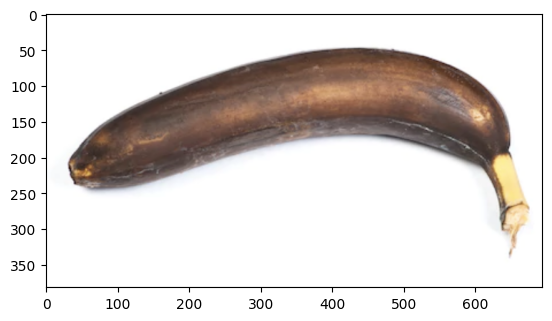

In [11]:
#Rotten example:
show_image('/content/sample_data/train/rottenfruits/vertical_flip_Screen Shot 2018-06-12 at 9.27.35 PM.png')

(254, 418, 3)


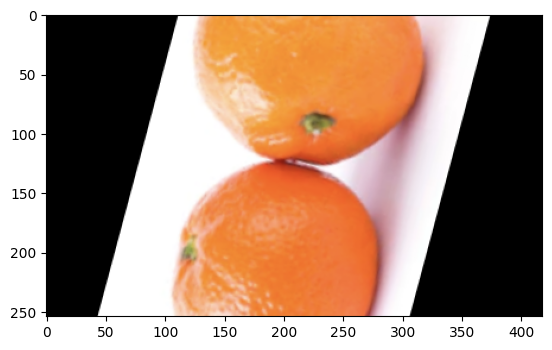

In [12]:
#Fresh Example:
show_image("/content/sample_data/train/freshfruits/rotated_by_75_Screen Shot 2018-06-13 at 12.15.21 AM.png")

In [13]:
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False);

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
base_model.trainable = False

In [15]:
# Create inputs with correct shape
inputs =  keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(1,activation = 'sigmoid')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), metrics=[keras.metrics.BinaryAccuracy()])

In [18]:
datagen_train = ImageDataGenerator(
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontaly
    vertical_flip=True, # randomly flip images verticaly
)  

datagen_valid = ImageDataGenerator(samplewise_center=True)

In [19]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    '/content/sample_data/train',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary"
)

# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    '/content/sample_data/validation',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary"
)

Found 10901 images belonging to 2 classes.
Found 2698 images belonging to 2 classes.


In [ ]:
model.fit(train_it,
          validation_data = valid_it,
          steps_per_epoch = train_it.samples/train_it.batch_size, # 340
          validation_steps = valid_it.samples/valid_it.batch_size, # 340
          epochs = 3)

Epoch 1/3
 53/340 [===>..........................] - ETA: 1:30:18 - loss: 0.8481 - binary_accuracy: 0.7217

In [ ]:
model.evaluate(valid_it, steps=valid_it.samples/valid_it.batch_size)

In [ ]:
def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

In [ ]:
make_predictions('/content/sample_data/validation/freshfruits/vertical_flip_Screen Shot 2018-06-13 at 12.18.07 AM.png')

In [ ]:
make_predictions('/content/sample_data/train/rottenfruits/vertical_flip_Screen Shot 2018-06-12 at 9.27.22 PM.png')

In [ ]:
make_predictions('/content/sample_data/train/rottenfruits/vertical_flip_Screen Shot 2018-06-08 at 2.42.52 PM.png')

In [ ]:
def fresh_or_rotten(image_path):
    preds = make_predictions(image_path)
    if preds <= 0.5:
        print("It's Fresh! eat ahead.")
    else:
        print("It's Rotten, I wont recommend!")

In [ ]:
#This data from validation so it should not be use to test the model but we just want to try it
fresh_or_rotten('/content/sample_data/validation/rottenfruits/Screen Shot 2018-06-12 at 11.20.59 PM.png')